<a href="https://colab.research.google.com/github/gg5d/Sequential_GD/blob/main/naive_ANN_with_seq_GD_NN_class_Updated_Activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
from numpy.random import uniform, randint, randn, normal
import sys
from timeit import default_timer as dt
import matplotlib.pylab as plt
import time

In [87]:
class NeuralNetwork:
    """
    A flexible neural network class that supports configurable architectures.

    Attributes:
        layer_sizes (list): List of integers defining the number of neurons in each layer
                           [input_size, hidden1, hidden2, ..., output_size]
        weights (list): List of weight matrices for each layer
        biases (list): List of bias vectors for each layer
        activations (list): Stores activations during forward pass
    """

    def __init__(self, layer_sizes: list, initialization='normal', seed=None):
        """
        Initialize the neural network with given architecture.

        Args:
            layer_sizes: List of layer sizes, e.g., [2, 2, 3, 4, 4, 4, 2] for 6 hidden layers
            initialization: 'normal' for normal distribution, 'xavier' for Xavier initialization
            seed: Random seed for reproducibility
        """
        if seed is not None:
            np.random.seed(seed)

        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes) - 1  # Number of weight layers
        self.weights = []
        self.biases = []
        self.activations = []

        # Initialize weights and biases
        for i in range(self.n_layers):
            input_size = layer_sizes[i]
            output_size = layer_sizes[i + 1]

            if initialization == 'xavier':
                # Xavier/Glorot initialization
                limit = np.sqrt(6.0 / (input_size + output_size))
                W = np.random.uniform(-limit, limit, (output_size, input_size))
            else:
                # Normal initialization (default)
                W = normal(size=(output_size, input_size))

            b = normal(size=(output_size, 1))

            self.weights.append(W)
            self.biases.append(b)

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Sigmoid activation function."""
        # Clip to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a: np.ndarray) -> np.ndarray:
        """Derivative of sigmoid activation function."""
        return a * (1 - a)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Perform forward pass through the network.

        Args:
            x: Input vector of shape (input_size, 1)

        Returns:
            Output vector of shape (output_size, 1)
        """
        self.activations = [x]  # Store input as first activation

        # Forward pass through all layers
        current_activation = x
        for W, b in zip(self.weights, self.biases):
            z = np.dot(W, current_activation) + b
            current_activation = self.sigmoid(z)
            self.activations.append(current_activation)

        return current_activation

    def backward(self, y: np.ndarray, learning_rate: float, method: str = 'standard'):
        """
        Perform backward pass and update weights using backpropagation.

        Args:
            y: True label vector of shape (output_size, 1)
            learning_rate: Learning rate for weight updates
            method: Backpropagation method to use:
                'standard' - Standard GD: Calculate all deltas first, then update all weights
                'sequential' - Sequential GD (poster): Update weights immediately, use updated weights
                              for next delta calculation, but DON'T recalculate activations
                'sequential_recalc' - Sequential GD with recalculation: Update weights immediately,
                                    recalculate activations with new weights, then compute next delta
        """
        if method == 'sequential':
            # ========================================================================
            # METHOD 1: Sequential GD WITHOUT recalculation (Poster's version)
            # ========================================================================
            # - Update weights layer-by-layer from output to input
            # - Use UPDATED weights for computing subsequent deltas
            # - Use ORIGINAL activations from forward pass (no recalculation)

            current_delta = None

            for i in range(self.n_layers - 1, -1, -1):  # From last layer to first
                if i == self.n_layers - 1:
                    # Output layer: δ[L] = σ'(a[L]) ◦ (a[L] - y)
                    output = self.activations[-1]
                    current_delta = output * (1 - output) * (output - y)
                else:
                    # Hidden layers: δ[l] = σ'(a[l]) ◦ (W̃[l+1])^T δ[l+1]
                    # Note: Using UPDATED weights from layer i+1 (modified in previous iteration)
                    activation = self.activations[i + 1]
                    current_delta = (activation * (1 - activation) *
                                    np.dot(self.weights[i + 1].T, current_delta))

                # Update weights and biases for current layer
                prev_activation = self.activations[i]
                self.weights[i] -= learning_rate * current_delta * prev_activation.T
                self.biases[i] -= learning_rate * current_delta

                # NO recalculation of activations

        elif method == 'sequential_recalc':
            # ========================================================================
            # METHOD 2: Sequential GD WITH recalculation (Original code)
            # ========================================================================
            # - Update weights layer-by-layer from output to input
            # - Use UPDATED weights for computing subsequent deltas
            # - RECALCULATE activations with new weights after each update

            current_delta = None

            for i in range(self.n_layers - 1, -1, -1):  # From last layer to first
                if i == self.n_layers - 1:
                    # Output layer
                    output = self.activations[-1]
                    current_delta = output * (1 - output) * (output - y)
                else:
                    # Hidden layers: use updated weights from previous iteration
                    activation = self.activations[i + 1]
                    current_delta = (activation * (1 - activation) *
                                    np.dot(self.weights[i + 1].T, current_delta))

                # Update weights and biases for current layer
                prev_activation = self.activations[i]
                self.weights[i] -= learning_rate * current_delta * prev_activation.T
                self.biases[i] -= learning_rate * current_delta

                # RECALCULATE activation for this layer with NEW weights
                if i > 0:  # Not needed for input layer
                    z = np.dot(self.weights[i], prev_activation) + self.biases[i]
                    self.activations[i + 1] = self.sigmoid(z)

        else:  # method == 'standard'
            # ========================================================================
            # METHOD 3: Standard GD (Classic Backpropagation)
            # ========================================================================
            # - Calculate ALL deltas first using original weights
            # - Then update ALL weights at once
            # - No recalculation of activations

            output = self.activations[-1]
            deltas = []

            # Calculate output layer delta
            delta = output * (1 - output) * (output - y)
            deltas.append(delta)

            # Backpropagate through hidden layers (all using ORIGINAL weights)
            for i in range(self.n_layers - 2, -1, -1):
                delta = (self.activations[i + 1] * (1 - self.activations[i + 1]) *
                        np.dot(self.weights[i + 1].T, deltas[0]))
                deltas.insert(0, delta)

            # Update all weights and biases at once
            for i in range(self.n_layers):
                delta = deltas[i]
                prev_activation = self.activations[i]

                self.weights[i] -= learning_rate * delta * prev_activation.T
                self.biases[i] -= learning_rate * delta

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Make a prediction for a single input.

        Args:
            x: Input vector of shape (input_size, 1)

        Returns:
            Output vector of shape (output_size, 1)
        """
        return self.forward(x)

    def predict_batch(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions for multiple inputs.

        Args:
            X: Input matrix of shape (n_samples, input_size) or list of (input_size, 1) vectors

        Returns:
            Output matrix of shape (n_samples, output_size)
        """
        if isinstance(X, list):
            predictions = []
            for x in X:
                pred = self.forward(x)
                predictions.append(pred.ravel())
            return np.array(predictions).T
        else:
            # Assume X is (n_samples, input_size)
            predictions = []
            for i in range(X.shape[0]):
                x = X[i:i+1, :].T  # Convert to column vector
                pred = self.forward(x)
                predictions.append(pred.ravel())
            return np.array(predictions).T

    def compute_cost(self, x1: np.ndarray, x2: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate the cost (error) of the network predictions.

        Args:
            x1, x2: Input feature arrays
            y: True labels of shape (output_size, n_samples)

        Returns:
            Total squared L2 norm of prediction errors
        """
        n_samples = len(x1)
        costvec = np.zeros((n_samples, 1))

        for i in range(n_samples):
            x = np.array([[x1[i]], [x2[i]]])
            output = self.forward(x)
            costvec[i] = np.linalg.norm(output.ravel() - y[:, i], 2)

        return np.linalg.norm(costvec, 2)**2

    def get_weights(self) -> tuple:
        """Return all weights and biases as separate variables (for backward compatibility)."""
        return self.weights, self.biases

    def copy(self):
        """Create a deep copy of the network."""
        new_net = NeuralNetwork(self.layer_sizes)
        new_net.weights = [W.copy() for W in self.weights]
        new_net.biases = [b.copy() for b in self.biases]
        return new_net

    def __repr__(self):
        """String representation of the network."""
        return f"NeuralNetwork(architecture={self.layer_sizes}, n_layers={self.n_layers})"


In [88]:
# ========== NEURAL NETWORK INITIALIZATION USING CLASS ==========
# Define the network architecture: [input_size, hidden1, hidden2, ..., output_size]
# Current architecture matches the original: 2 inputs -> 6 hidden layers -> 2 outputs
architecture = [2, 10, 10, 10, 10, 10, 2]  # 6 hidden layers

SEED = 42

# Create two networks: one for standard GD, one for sequential GD
nn_gd = NeuralNetwork(architecture, initialization='normal', seed=SEED)
nn_seq = nn_gd.copy()  # Create a copy with same initial weights
nn_seq_recalc = nn_gd.copy()  # Create a copy with same initial weights

print("Neural Network Initialized:")
print(f"Architecture: {architecture}")
print(f"Total layers (including input): {len(architecture)}")
print(f"Trainable weight layers: {nn_gd.n_layers}")
print(f"\nLayer details:")
for i, (W, b) in enumerate(zip(nn_gd.weights, nn_gd.biases)):
    print(f"  Layer {i+1}: {W.shape[1]} -> {W.shape[0]} neurons (W: {W.shape}, b: {b.shape})")

Neural Network Initialized:
Architecture: [2, 10, 10, 10, 10, 10, 2]
Total layers (including input): 7
Trainable weight layers: 6

Layer details:
  Layer 1: 2 -> 10 neurons (W: (10, 2), b: (10, 1))
  Layer 2: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 3: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 4: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 5: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 6: 10 -> 2 neurons (W: (2, 10), b: (2, 1))


In [89]:
# Added the point (0.5,0.8) as [1,0]
x1 = np.array([0.3,0.1, 0.3, 0.1, 0.4, 0.4, 0.6, 0.5, 0.9, 0.4, 0.7,0.4,0.5,0.5])
x2 = np.array([0.6,0.1, 0.4, 0.5, 0.9, 0.2, 0.3, 0.6, 0.2, 0.4, 0.6,0.7,0.7,0.8])



In [90]:
# previous assignment
y  = np.zeros((2, 14))
y[0,:6] = np.ones((1,  6))
#y[0,5: ] = np.zeros((1, 5))
y[1,6: ] = np.ones((1,  8))

In [91]:
# Do not use it yet
# Random assignment of labels

np.random.seed(SEED)

n_samples = len(x1) # Ensure y has the same number of samples as x1, x2
y = np.zeros((2, n_samples))

# Randomly assign each sample to Class 0 ([1,0]) or Class 1 ([0,1])
for i in range(n_samples):
    if np.random.rand() > 0.5: # 50% chance for each class
        y[0, i] = 1 # Class 0: [1, 0]
    else:
        y[1, i] = 1 # Class 1: [0, 1]

print("Generated random y:")
print(y)

Generated random y:
[[0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.]]


In [92]:
# prompt: print x1, x2, and y

print("x1:", x1)
print("x2:", x2)
print("y:\n", y)


x1: [0.3 0.1 0.3 0.1 0.4 0.4 0.6 0.5 0.9 0.4 0.7 0.4 0.5 0.5]
x2: [0.6 0.1 0.4 0.5 0.9 0.2 0.3 0.6 0.2 0.4 0.6 0.7 0.7 0.8]
y:
 [[0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.]]


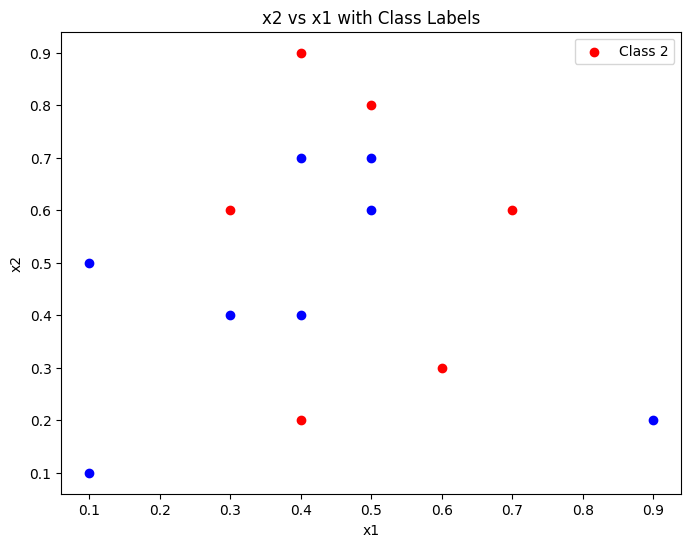

In [93]:
# prompt: plot x2 vs x1 and label them based on y

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(y.shape[1]):
  if y[0, i] == 1 and y[1, i] == 0:
    plt.scatter(x1[i], x2[i], color='blue', label='Class 1' if i == 0 else '')
  else:
    plt.scatter(x1[i], x2[i], color='red', label='Class 2' if i == 5 else '')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('x2 vs x1 with Class Labels')
plt.legend()
plt.show()


In [94]:
# ========== TRAINING WITH NEURAL NETWORK CLASS ==========
# Training hyperparameters
learning_rate = 0.05
learning_rate_seq = 0.05
Niter = 2000000
cost_calc_frequency = 10000  # Calculate full cost every N iterations (for efficiency)

# Initialize tracking arrays
cost_value_class = np.zeros((Niter, 1))
cost_value_seq_class = np.zeros((Niter, 1))
cost_value_seq_recalc = np.zeros((Niter, 1))

diff_output_class = np.zeros((Niter, 1))
diff_output_class_recalc = np.zeros((Niter, 1))

print(f"Starting training for {Niter} iterations...")
print(f"Using NeuralNetwork class with architecture: {architecture}")
start_time = time.time()

for counter in range(Niter):
    # Randomly select a training sample (stochastic gradient descent)
    k = randint(y.shape[1])
    xvec = np.array([[x1[k]], [x2[k]]])
    yvec = y[:, k:k+1]  # Keep as column vector

    # ========== STANDARD GD ==========
    output_gd = nn_gd.forward(xvec)
    nn_gd.backward(yvec, learning_rate, method='standard')

    # ========== SEQUENTIAL GD ==========
    output_seq = nn_seq.forward(xvec)
    nn_seq.backward(yvec, learning_rate_seq, method='sequential')

    # ========== SEQUENTIAL RECALC GD ==============
    output_seq_recalc = nn_seq_recalc.forward(xvec)
    nn_seq_recalc.backward(yvec, learning_rate_seq, method ='sequential_recalc')


    # Calculate cost (less frequently for efficiency)
    if counter % cost_calc_frequency == 0 or counter == Niter - 1:
        cost_value_class[counter] = nn_gd.compute_cost(x1, x2, y)
        cost_value_seq_class[counter] = nn_seq.compute_cost(x1, x2, y)
        cost_value_seq_recalc[counter] = nn_seq_recalc.compute_cost(x1, x2, y)
    else:
        # Interpolate or copy previous value for efficiency
        cost_value_class[counter] = cost_value_class[counter - 1] if counter > 0 else 0
        cost_value_seq_class[counter] = cost_value_seq_class[counter - 1] if counter > 0 else 0
        cost_value_seq_recalc[counter] = cost_value_seq_recalc[counter - 1] if counter > 0 else 0

    # Track difference between outputs
    diff_output_class[counter] = np.linalg.norm(output_gd.ravel() - output_seq.ravel(), 2)
    diff_output_class_recalc[counter] = np.linalg.norm(output_seq.ravel() - output_seq_recalc.ravel(), 2)

    # Progress indicator
    if (counter + 1) % (Niter // 10) == 0:
        elapsed = time.time() - start_time
        print(f"Progress: {100 * (counter + 1) / Niter:.1f}% | "
              f"Cost (GD): {cost_value_class[counter][0]:.6f}, (Seq GD): {cost_value_seq_class[counter][0]:.6f}, Cost(Seq_Rec GD): {cost_value_seq_recalc[counter][0]:.6f} | "
              f"Time: {elapsed:.1f}s")

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds")
print(f"Final costs - GD: {cost_value_class[-1][0]:.6f}, Sequential GD: {cost_value_seq_class[-1][0]:.6f}, Seq_Rec GD: {cost_value_seq_recalc[-1][0]:.6f}")

Starting training for 2000000 iterations...
Using NeuralNetwork class with architecture: [2, 10, 10, 10, 10, 10, 2]
Progress: 10.0% | Cost (GD): 3.504250, (Seq GD): 3.594251, Cost(Seq_Rec GD): 3.594251 | Time: 36.7s
Progress: 20.0% | Cost (GD): 0.074621, (Seq GD): 3.428103, Cost(Seq_Rec GD): 3.428103 | Time: 73.1s
Progress: 30.0% | Cost (GD): 0.006734, (Seq GD): 3.527841, Cost(Seq_Rec GD): 3.527841 | Time: 110.2s
Progress: 40.0% | Cost (GD): 0.003490, (Seq GD): 2.531305, Cost(Seq_Rec GD): 2.531305 | Time: 147.2s
Progress: 50.0% | Cost (GD): 0.002343, (Seq GD): 2.411667, Cost(Seq_Rec GD): 2.411667 | Time: 184.1s
Progress: 60.0% | Cost (GD): 0.001757, (Seq GD): 2.442466, Cost(Seq_Rec GD): 2.442466 | Time: 220.7s
Progress: 70.0% | Cost (GD): 0.001404, (Seq GD): 2.410059, Cost(Seq_Rec GD): 2.410059 | Time: 257.3s
Progress: 80.0% | Cost (GD): 0.001168, (Seq GD): 2.407578, Cost(Seq_Rec GD): 2.407578 | Time: 293.8s
Progress: 90.0% | Cost (GD): 0.000999, (Seq GD): 2.416242, Cost(Seq_Rec GD): 2

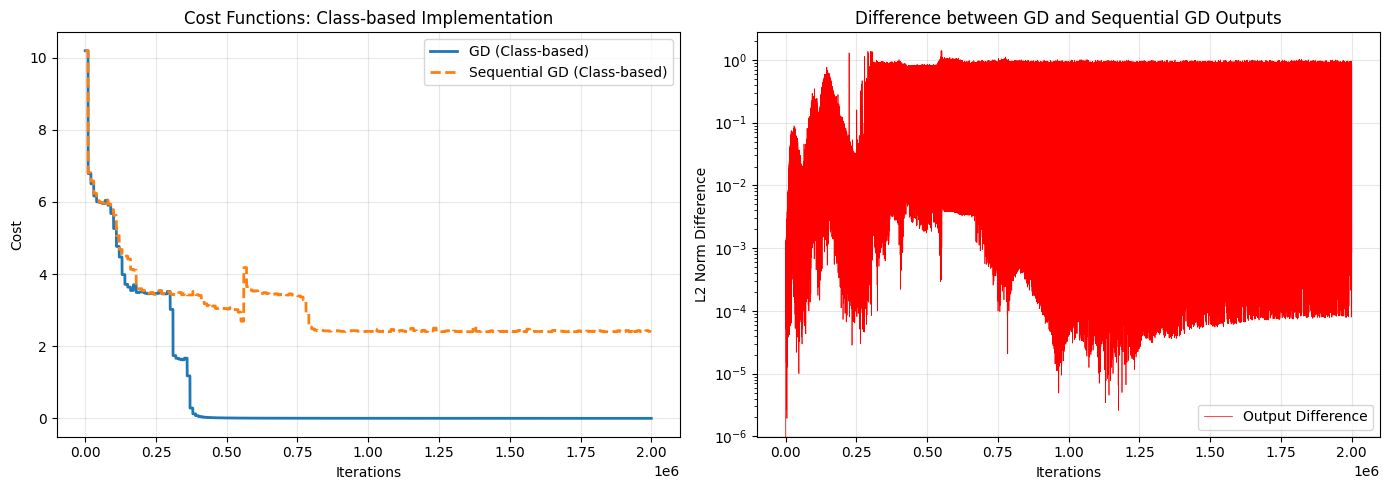


=== Training Statistics ===
Final Cost (GD): 0.000867
Final Cost (Seq GD): 2.410742
Final Output Difference: 0.000959


In [95]:
# ========== VISUALIZE TRAINING RESULTS ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot cost functions
axes[0].plot(cost_value_class, label='GD (Class-based)', linewidth=2)
axes[0].plot(cost_value_seq_class, linestyle='--', label='Sequential GD (Class-based)', linewidth=2)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Cost')
axes[0].set_title('Cost Functions: Class-based Implementation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot output differences
axes[1].plot(diff_output_class, label='Output Difference', color='red', linewidth=0.5)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('L2 Norm Difference')
axes[1].set_title('Difference between GD and Sequential GD Outputs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('training_results_class_based.png', dpi=150)
plt.show()

# Print final statistics
print("\n=== Training Statistics ===")
print(f"Final Cost (GD): {cost_value_class[-1][0]:.6f}")
print(f"Final Cost (Seq GD): {cost_value_seq_class[-1][0]:.6f}")
print(f"Final Output Difference: {diff_output_class[-1][0]:.6f}")


Computing decision boundaries...


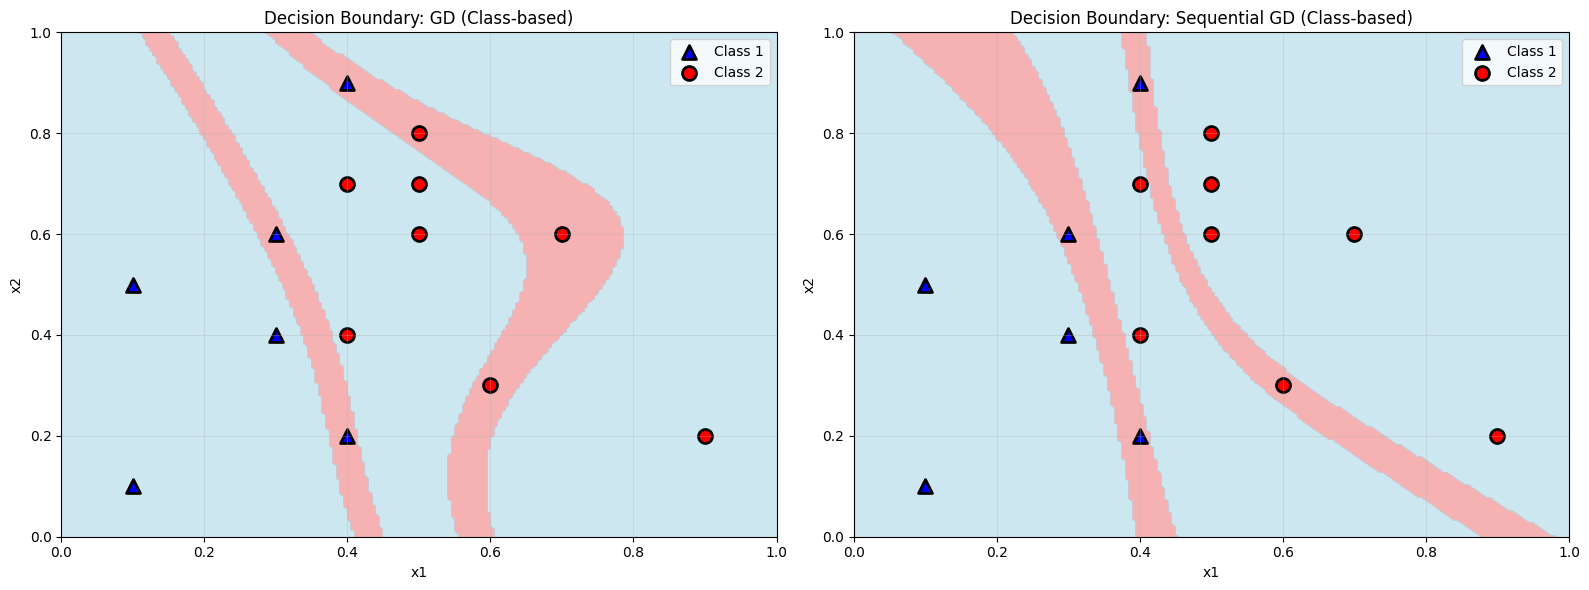

Decision boundaries computed and visualized!


In [96]:
# ========== DECISION BOUNDARY VISUALIZATION ==========
# Create a meshgrid for decision boundary visualization
X, Y = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
X1Test = X.ravel()
X2Test = Y.ravel()

# Predictions for GD network
predictions_gd = np.zeros(200 * 200)
predictions_seq = np.zeros(200 * 200)

print("Computing decision boundaries...")
for i in range(len(X1Test)):
    xvec = np.array([[X1Test[i]], [X2Test[i]]])

    # GD predictions
    output_gd = nn_gd.predict(xvec)
    predictions_gd[i] = 1 if output_gd[0] >= output_gd[1] else 0

    # Sequential GD predictions
    output_seq = nn_seq.predict(xvec)
    predictions_seq[i] = 1 if output_seq[0] >= output_seq[1] else 0

YPred_gd = predictions_gd.reshape((200, 200))
YPred_seq = predictions_seq.reshape((200, 200))

# Plot decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# GD decision boundary
axes[0].contourf(X, Y, YPred_gd, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'], alpha=0.6)
axes[0].scatter(x1[:6], x2[:6], marker='^', s=100, c='blue', edgecolors='black', linewidths=2, label='Class 1')
axes[0].scatter(x1[6:], x2[6:], marker='o', s=100, c='red', edgecolors='black', linewidths=2, label='Class 2')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Decision Boundary: GD (Class-based)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sequential GD decision boundary
axes[1].contourf(X, Y, YPred_seq, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'], alpha=0.6)
axes[1].scatter(x1[:6], x2[:6], marker='^', s=100, c='blue', edgecolors='black', linewidths=2, label='Class 1')
axes[1].scatter(x1[6:], x2[6:], marker='o', s=100, c='red', edgecolors='black', linewidths=2, label='Class 2')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
axes[1].set_title('Decision Boundary: Sequential GD (Class-based)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('decision_boundaries_class_based.png', dpi=150)
plt.show()

print("Decision boundaries computed and visualized!")


## Example: Using Different Architectures

The `NeuralNetwork` class allows you to easily experiment with different architectures. Here are some examples:


In [ ]:
# ========== EXAMPLE: DIFFERENT ARCHITECTURES ==========
# You can easily create networks with different architectures

# Example 1: Simpler network (3 layers: 2 -> 4 -> 2)
simple_arch = [2, 4, 2]
nn_simple = NeuralNetwork(simple_arch, initialization='normal')
print(f"Simple architecture: {simple_arch}")
print(f"  {nn_simple}\n")

# Example 2: Deeper network (8 layers)
deep_arch = [2, 3, 4, 5, 6, 5, 4, 3, 2]
nn_deep = NeuralNetwork(deep_arch, initialization='xavier')  # Using Xavier initialization
print(f"Deep architecture: {deep_arch}")
print(f"  {nn_deep}\n")

# Example 3: Wide network (fewer layers, more neurons)
wide_arch = [2, 10, 10, 2]
nn_wide = NeuralNetwork(wide_arch, initialization='normal')
print(f"Wide architecture: {wide_arch}")
print(f"  {nn_wide}\n")

# Example 4: Test prediction with simple network
test_input = np.array([[0.5], [0.5]])
test_output = nn_simple.predict(test_input)
print(f"Test prediction (input: [0.5, 0.5]): {test_output.ravel()}")


# MNIST Dataset

In [ ]:
# =============================================================================
# MNIST Comparison: Standard GD vs Sequential GD vs Sequential GD + Recalc
# =============================================================================
!pip install scikit-learn
!pip install pandas
from sklearn.datasets import fetch_openml

# Load MNIST
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist, y_mnist_labels = mnist.data / 255.0, mnist.target.astype(int)

# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((num_classes, len(labels)))
    one_hot[labels, np.arange(len(labels))] = 1
    return one_hot

y_mnist = one_hot_encode(y_mnist_labels)
n_samples = X_mnist.shape[0]

print(f"MNIST loaded: {n_samples} samples, {X_mnist.shape[1]} features, {y_mnist.shape[0]} classes")



Starting MNIST training for 100000 iterations...
Using NeuralNetwork class with architecture: [784, 128, 64, 10]
Progress: 10.0% | Cost (GD): 51.244133, (Seq GD): 350.941451, (Seq_Rec GD): 350.941451 | Time: 13.5s
Progress: 20.0% | Cost (GD): 24.624333, (Seq GD): 186.780326, (Seq_Rec GD): 186.780326 | Time: 27.3s
Progress: 30.0% | Cost (GD): 16.147580, (Seq GD): 108.567980, (Seq_Rec GD): 108.567980 | Time: 40.5s
Progress: 40.0% | Cost (GD): 16.699501, (Seq GD): 56.382872, (Seq_Rec GD): 56.382872 | Time: 54.1s
Progress: 50.0% | Cost (GD): 12.292327, (Seq GD): 90.244809, (Seq_Rec GD): 90.244809 | Time: 67.7s
Progress: 60.0% | Cost (GD): 12.687067, (Seq GD): 102.247612, (Seq_Rec GD): 102.247612 | Time: 81.3s
Progress: 70.0% | Cost (GD): 9.829642, (Seq GD): 149.612776, (Seq_Rec GD): 149.612776 | Time: 94.8s
Progress: 80.0% | Cost (GD): 8.228195, (Seq GD): 28.260262, (Seq_Rec GD): 28.260262 | Time: 108.1s
Progress: 90.0% | Cost (GD): 7.973609, (Seq GD): 46.581941, (Seq_Rec GD): 46.581941 | 

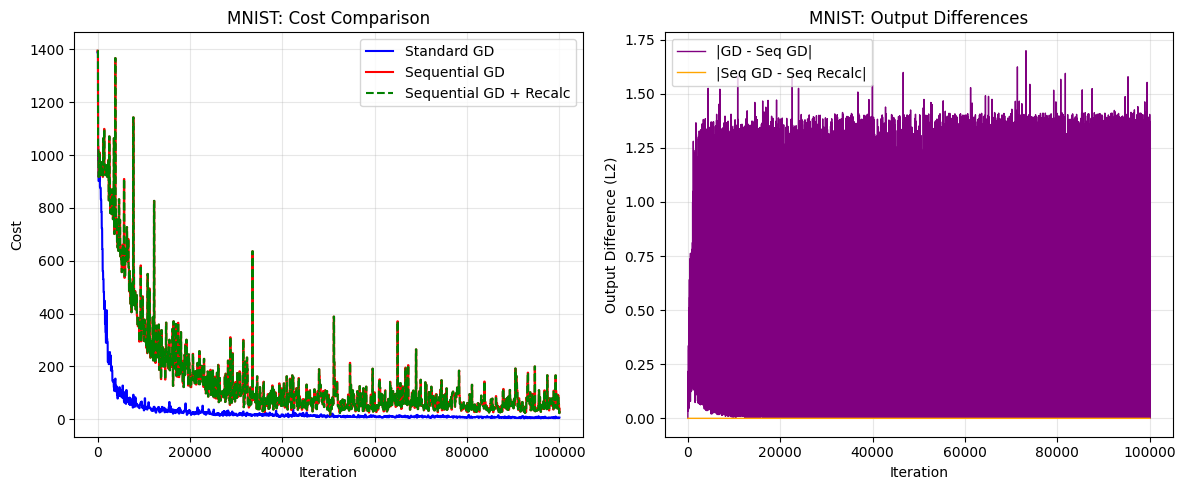

In [106]:
# Network architecture for MNIST
architecture_mnist = [784, 128, 64, 10]
SEED = 42

# Create 3 networks with identical initial weights
nn_gd_mnist = NeuralNetwork(architecture_mnist, initialization='xavier', seed=SEED)
nn_seq_mnist = NeuralNetwork(architecture_mnist, initialization='xavier', seed=SEED)
nn_seq_recalc_mnist = NeuralNetwork(architecture_mnist, initialization='xavier', seed=SEED)

# Copy weights to ensure identical starting point
nn_seq_mnist.weights = [W.copy() for W in nn_gd_mnist.weights]
nn_seq_mnist.biases = [b.copy() for b in nn_gd_mnist.biases]
nn_seq_recalc_mnist.weights = [W.copy() for W in nn_gd_mnist.weights]
nn_seq_recalc_mnist.biases = [b.copy() for b in nn_gd_mnist.biases]

# Training hyperparameters
learning_rate_mnist = 0.5
learning_rate_seq_mnist = 0.5
Niter_mnist = 100000
cost_calc_frequency_mnist = 100

# Initialize tracking arrays
cost_value_gd_mnist = np.zeros((Niter_mnist, 1))
cost_value_seq_mnist = np.zeros((Niter_mnist, 1))
cost_value_seq_recalc_mnist = np.zeros((Niter_mnist, 1))

diff_output_mnist = np.zeros((Niter_mnist, 1))
diff_output_recalc_mnist = np.zeros((Niter_mnist, 1))

print(f"Starting MNIST training for {Niter_mnist} iterations...")
print(f"Using NeuralNetwork class with architecture: {architecture_mnist}")
start_time = time.time()

for counter in range(Niter_mnist):
    # Randomly select a training sample (stochastic gradient descent)
    k = randint(n_samples)
    xvec = X_mnist[k:k+1].T  # Shape: (784, 1)
    yvec = y_mnist[:, k:k+1]  # Shape: (10, 1)

    # ========== STANDARD GD ==========
    output_gd = nn_gd_mnist.forward(xvec)
    nn_gd_mnist.backward(yvec, learning_rate_mnist, method='standard')

    # ========== SEQUENTIAL GD ==========
    output_seq = nn_seq_mnist.forward(xvec)
    nn_seq_mnist.backward(yvec, learning_rate_seq_mnist, method='sequential')

    # ========== SEQUENTIAL RECALC GD ==============
    output_seq_recalc = nn_seq_recalc_mnist.forward(xvec)
    nn_seq_recalc_mnist.backward(yvec, learning_rate_seq_mnist, method='sequential_recalc')

    # Calculate cost (less frequently for efficiency)
    if counter % cost_calc_frequency_mnist == 0 or counter == Niter_mnist - 1:
        # Compute cost on a subset for efficiency
        cost_gd, cost_seq, cost_recalc = 0, 0, 0
        eval_samples = 1000
        eval_indices = np.random.choice(n_samples, eval_samples, replace=False)
        for idx in eval_indices:
            x_eval = X_mnist[idx:idx+1].T
            y_eval = y_mnist[:, idx]
            cost_gd += np.linalg.norm(nn_gd_mnist.forward(x_eval).ravel() - y_eval, 2)
            cost_seq += np.linalg.norm(nn_seq_mnist.forward(x_eval).ravel() - y_eval, 2)
            cost_recalc += np.linalg.norm(nn_seq_recalc_mnist.forward(x_eval).ravel() - y_eval, 2)
        cost_value_gd_mnist[counter] = cost_gd ** 2 / eval_samples
        cost_value_seq_mnist[counter] = cost_seq ** 2 / eval_samples
        cost_value_seq_recalc_mnist[counter] = cost_recalc ** 2 / eval_samples
    else:
        cost_value_gd_mnist[counter] = cost_value_gd_mnist[counter - 1] if counter > 0 else 0
        cost_value_seq_mnist[counter] = cost_value_seq_mnist[counter - 1] if counter > 0 else 0
        cost_value_seq_recalc_mnist[counter] = cost_value_seq_recalc_mnist[counter - 1] if counter > 0 else 0

    # Track difference between outputs
    diff_output_mnist[counter] = np.linalg.norm(output_gd.ravel() - output_seq.ravel(), 2)
    diff_output_recalc_mnist[counter] = np.linalg.norm(output_seq.ravel() - output_seq_recalc.ravel(), 2)

    # Progress indicator
    if (counter + 1) % (Niter_mnist // 10) == 0:
        elapsed = time.time() - start_time
        print(f"Progress: {100 * (counter + 1) / Niter_mnist:.1f}% | "
              f"Cost (GD): {cost_value_gd_mnist[counter][0]:.6f}, (Seq GD): {cost_value_seq_mnist[counter][0]:.6f}, (Seq_Rec GD): {cost_value_seq_recalc_mnist[counter][0]:.6f} | "
              f"Time: {elapsed:.1f}s")

elapsed_time = time.time() - start_time
print(f"\nMNIST Training completed in {elapsed_time:.2f} seconds")
print(f"Final costs - GD: {cost_value_gd_mnist[-1][0]:.6f}, Sequential GD: {cost_value_seq_mnist[-1][0]:.6f}, Seq_Rec GD: {cost_value_seq_recalc_mnist[-1][0]:.6f}")

# ========== PLOT MNIST RESULTS ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cost_value_gd_mnist, 'b-', linewidth=1.5, label='Standard GD')
plt.plot(cost_value_seq_mnist, 'r-', linewidth=1.5, label='Sequential GD')
plt.plot(cost_value_seq_recalc_mnist, 'g--', linewidth=1.5, label='Sequential GD + Recalc')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('MNIST: Cost Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(diff_output_mnist, 'purple', linewidth=1, label='|GD - Seq GD|')
plt.plot(diff_output_recalc_mnist, 'orange', linewidth=1, label='|Seq GD - Seq Recalc|')
plt.xlabel('Iteration')
plt.ylabel('Output Difference (L2)')
plt.title('MNIST: Output Differences')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnist_backprop_comparison.png', dpi=150)
plt.show()